# CNN architecture  with Pytorch

In [47]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.utils.data as data_utils
import torchvision.transforms as transforms
from scipy.io import loadmat
import os
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
from torchvision import transforms

In [48]:
# Load the data from the SVHN dataset
train = loadmat('train_32x32.mat')
test = loadmat('test_32x32.mat')
# Change the labels for number 0
train['y'][train['y'] == 10] = 0
test['y'][test['y'] == 10] = 0

In [49]:
print("Train features shape: {}".format(train['X'].shape))
print("Test features shape: {}".format(test['X'].shape))
print("Train labels shape: {}".format(train['y'].shape))
print("Test labels shape: {}".format(test['y'].shape))

Train features shape: (32, 32, 3, 73257)
Test features shape: (32, 32, 3, 26032)
Train labels shape: (73257, 1)
Test labels shape: (26032, 1)


We have 73257 train samples, each one represent a picture 32x32 with 3 color channels (RGB). For the test data we have 26032 samples. Pytorch accepts images in a different format, as first dimension is given the batch followed by the color channel and then the image height and width. We have to transpose the image and convert it to float. We also squeeze the labels so they will be a one dimensional array and we convert them to long type.

In [53]:
# Turn data into tensors
train_features_tensor = torch.from_numpy(train['X'] / 255.).permute(3, 2, 0, 1).float()
train_labels_tensor = torch.from_numpy(train['y']).squeeze().long()

test_features_tensor = torch.from_numpy(test['X'] / 255.).permute(3, 2, 0, 1).float()
test_labels_tensor = torch.from_numpy(test['y']).squeeze().long()

In [54]:
print("Train features shape: {}".format(train_features_tensor.shape))
print("Train labels shape: {}".format(train_labels_tensor.shape))
print("Test features shape: {}".format(test_features_tensor.shape))
print("Test labels shape: {}".format(test_labels_tensor.shape))

Train features shape: torch.Size([73257, 3, 32, 32])
Train labels shape: torch.Size([73257])
Test features shape: torch.Size([26032, 3, 32, 32])
Test labels shape: torch.Size([26032])


In [55]:
# Make a data loader
train_dataset = data_utils.TensorDataset(train_features_tensor, train_labels_tensor)
test_dataset = data_utils.TensorDataset(test_features_tensor, test_labels_tensor)

In [59]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=100,
                                           shuffle=True,
                                           num_workers=2)

test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=100,
                                          shuffle=True,
                                          num_workers=2)

In [100]:
# Build the network
in_channels = 3

out_channels_1 = 16
out_channels_2 = 32

out1_size = 1000
out2_size = 10

kernel_size = (5,5)


class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Create the first convolution layer, channel input is 3 for RGB images, the output is selected to have 16
        # filters, padding is set to 2 so we take as output the same dimensions as the original image.
        # Formula to calculate the output shape of the convolution layer [(W−K+2P)/S]+1.
        # out_shape_height = (7-3+0) + 1

        self.Conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels_1,
                               padding=1, kernel_size=kernel_size)
        # Initialize the weights with the Xavier initialization method, and set bias to 0
        nn.init.xavier_normal_(self.Conv1.weight)
        nn.init.constant_(self.Conv1.bias,0)

        self.layer1 = nn.Sequential(
            self.Conv1,
            nn.BatchNorm2d(out_channels_1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.Conv2 = nn.Conv2d(in_channels=out_channels_1, out_channels=out_channels_2,
                               kernel_size=kernel_size)
        nn.init.xavier_normal_(self.Conv2.weight)
        nn.init.constant_(self.Conv2.bias, 0)

        self.layer2 = nn.Sequential(
            self.Conv2,
            nn.BatchNorm2d(out_channels_2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.Dense = nn.Linear(32*5*5, out1_size)
        nn.init.xavier_normal_(self.Dense.weight)
        nn.init.constant_(self.Dense.bias, 0)
        self.layer3 = nn.Sequential(
            self.Dense,
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(out1_size, out2_size)
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.layer3(out)


        return F.log_softmax(out, dim=1)
    
    def compile(self):
        self.to(self.device)
        
    def fit(self,train_loader, optimizer, loss_function, num_epochs=10):
        loss_values = []
        for epoch in range(num_epochs):
            for i, (images, labels) in enumerate(train_loader):
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self(images)
                loss = loss_function(outputs, labels)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                if ((i + 1) % 100)==0:
                    print("Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}"
                              .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
                    loss_values.append(loss.item())
    
                    
        
        return loss_values
    
    
    def evaluate(self, test_loader):
        self.eval()

        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in test_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted==labels).sum().item()

            print('Accuracy of the model on the test set: {:.4f}%)'.format(100*correct / total))
            

        

In [101]:
model = ConvNet()
# device = torch.device('cuda:0')
# model.to(device)
model.compile()

In [102]:
learning_rate = 0.001
loss = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
total_step = len(train_loader)
num_epochs = 100
loss_values = list()

# Train the model

In [103]:
history = model.fit(train_loader=train_loader,optimizer=optimizer, loss_function=loss, num_epochs=10)

Epoch [1/10], Step [100/733], Loss: 0.6914
Epoch [1/10], Step [200/733], Loss: 0.8692
Epoch [1/10], Step [300/733], Loss: 0.6416
Epoch [1/10], Step [400/733], Loss: 0.4001
Epoch [1/10], Step [500/733], Loss: 0.5237
Epoch [1/10], Step [600/733], Loss: 0.8948
Epoch [1/10], Step [700/733], Loss: 0.4162
Epoch [2/10], Step [100/733], Loss: 0.4087
Epoch [2/10], Step [200/733], Loss: 0.3662
Epoch [2/10], Step [300/733], Loss: 0.4472
Epoch [2/10], Step [400/733], Loss: 0.4326
Epoch [2/10], Step [500/733], Loss: 0.4780
Epoch [2/10], Step [600/733], Loss: 0.3081
Epoch [2/10], Step [700/733], Loss: 0.2967
Epoch [3/10], Step [100/733], Loss: 0.6027
Epoch [3/10], Step [200/733], Loss: 0.2731
Epoch [3/10], Step [300/733], Loss: 0.6937
Epoch [3/10], Step [400/733], Loss: 0.3137
Epoch [3/10], Step [500/733], Loss: 0.4486
Epoch [3/10], Step [600/733], Loss: 0.3990
Epoch [3/10], Step [700/733], Loss: 0.3953
Epoch [4/10], Step [100/733], Loss: 0.3252
Epoch [4/10], Step [200/733], Loss: 0.2957
Epoch [4/10

## Plot the results

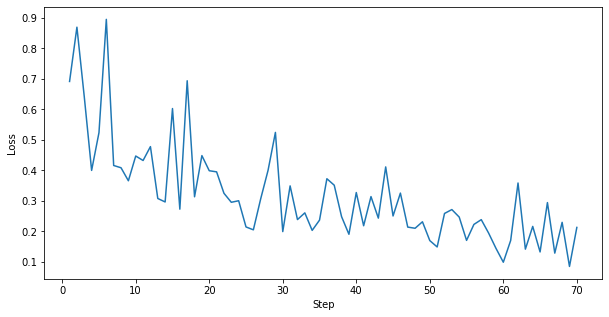

In [104]:
x=(range(1,len(history)+1))

plt.figure(figsize=(10, 5))
plt.plot(x, history)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()

## Evaluate the model

In [105]:
# model.eval()

# with torch.no_grad():
#     correct = 0
#     total = 0
#     for images, labels in test_loader:
#         images, labels = images.to(device), labels.to(device)
#         outputs = model(images)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted==labels).sum().item()
        
#     print('Accuracy of the model on the test images: {:.4f}%)'.format(100*correct / total))

model.evaluate(test_loader)

Accuracy of the model on the test set: 91.3299%)


## Test model's perfomance

True Label:  1  Predicted Label:  1


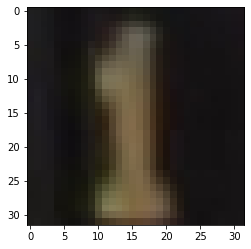

-------------
True Label:  0  Predicted Label:  0


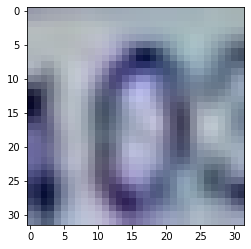

-------------
True Label:  4  Predicted Label:  4


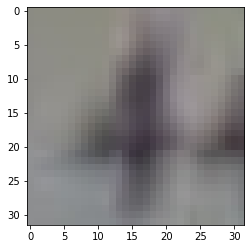

-------------
True Label:  3  Predicted Label:  3


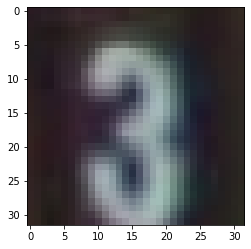

-------------
True Label:  0  Predicted Label:  0


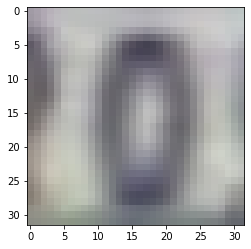

-------------


In [106]:
with torch.no_grad():
    images, labels = iter(test_loader).next()
    images = images.to(model.device)
    out_predict = model(images)
    _, predicted = torch.max(out_predict.data,1)
    for idx, each_image in enumerate(images[:5]):
        each_image = each_image.cpu().permute(1,2,0).numpy()
        image_label = labels[idx].cpu().numpy().squeeze()
        print("True Label: ", image_label, " Predicted Label: ",predicted[idx].cpu().numpy().squeeze()  )
        plt.imshow(each_image)
        plt.show()
        print("-------------")
        